
# Homework 3

This homework has four parts. 
1. In the first three parts you are asked to implement a CUDA version of exclusive scan. The algorithm to use is explained below in the section "Exclusive Scan".
2. In the fourth part you are asked to implement a CUDA version of  matrix transpose



# Exclusive scan
We perform exclusive prefix sum with the help of (a fictitious) binary tree. The sum is performed in two phases, an $\textbf{upsweep}$ and $\textbf{downsweep}$. 


## Upsweep

A simple example of the upsweep phase is shown in the figure below. Initially, the  array
contains the values [0,1,2,3,4,5,6,7]. At each step up the tree, the value of a node is the sum of its two children.

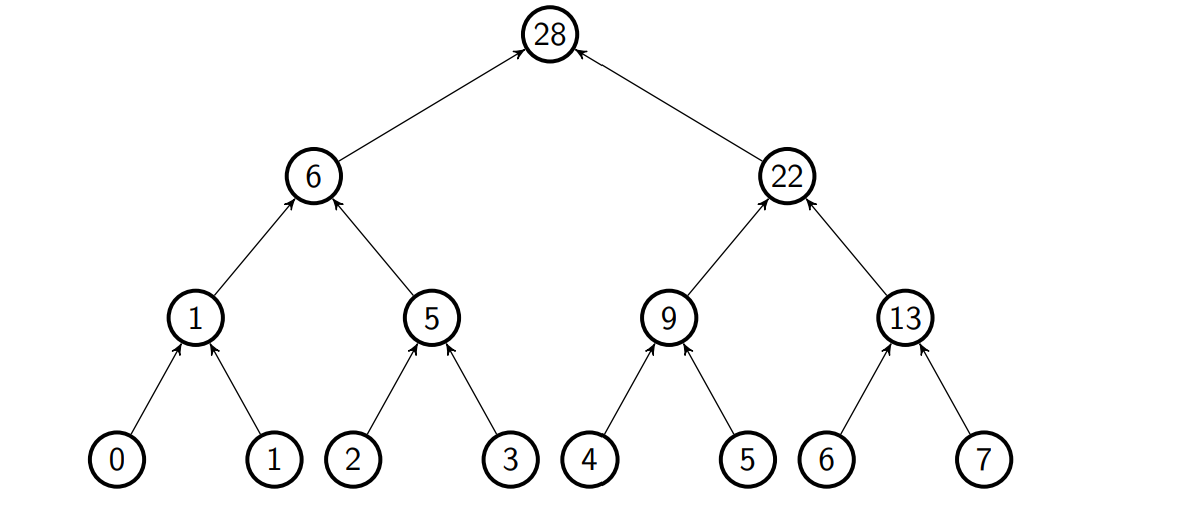

Note that the tree does not exist, it is just used to illustrate the behavior of the algorithm. The general case is illustrated in the figure below

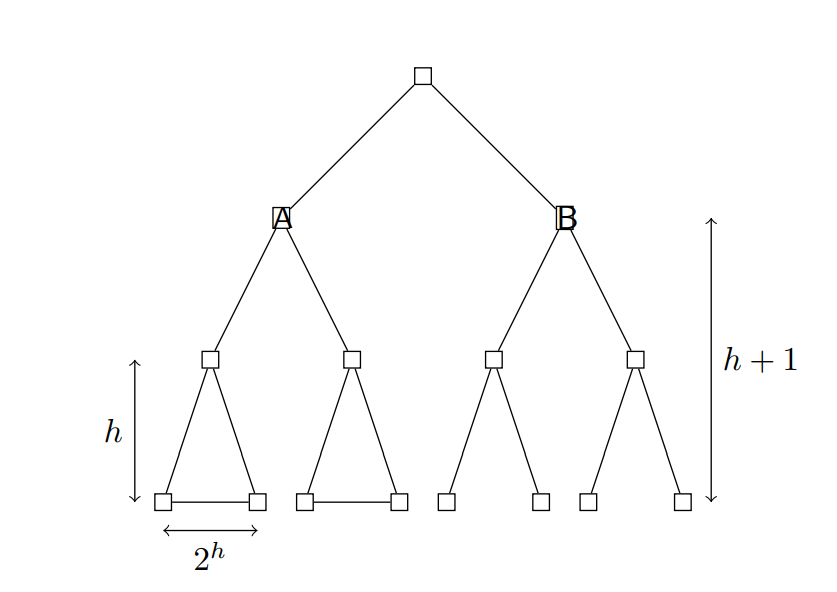


Recall that  a binary tree of height $h$ has $2^h$ leaves. Therefore the number of leaves in the tree rooted at $A$ is $2^{h+1}$ divided between the left and right children of $A$.
Since the algorithm does not actually construct a tree, the values needs to be stored in the array itself, replacing previous values. The value of a node is stored in the array at the index of its rightmost leaf. In the case of $A$, its left child is stored at $2^h-1$ and its right child is stored at $2^{h+1}-1$. Finally,
the index of node $A$ is at $2^{h+1}-1$. Let $S$ be the array then 
\begin{align*}
    S[2^{h+1}-1]=S[2^h-1]+S[2^{h+1}-1]
\end{align*}
For node $B$ it is the same except we shift the indices by $2^{h+1}$ to the right.
Therefore for nodes at level $h+1$ we have 
\begin{align*}
    S[k+2^{h+1}-1]=S[k+2^h-1]+S[k+2^{h+1}-1]
\end{align*}
where $k$ starts with 0 and is incremented by $2^{h+1}$. For a given height $h$, the operations are performed by the following for loop.

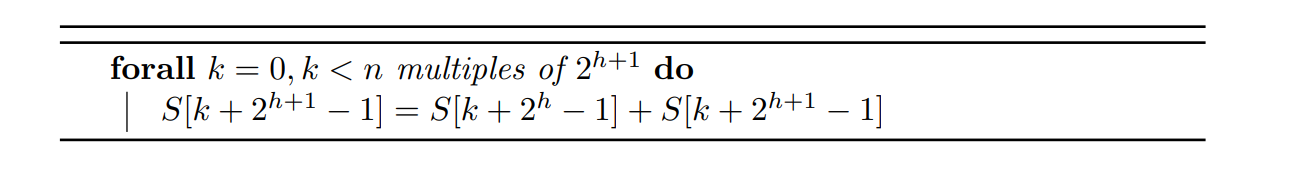

Since this is done for all heights, the algorithm becomes:
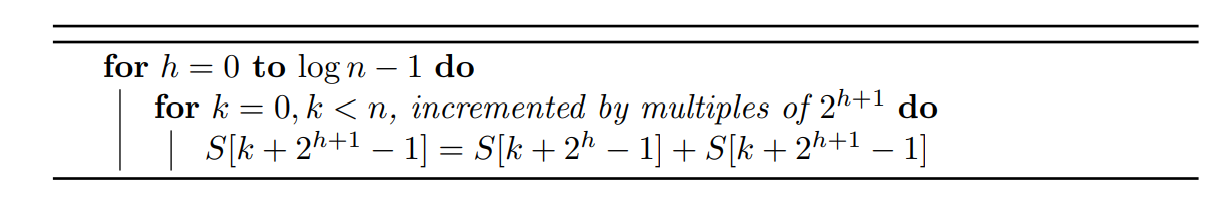

Now, multiples of $2^{h+1}$ can be write as $\alpha 2^{h+1}$ with $\alpha=0,\ldots,d-1$ with $d=\frac{n}{2^{h+1}}$.
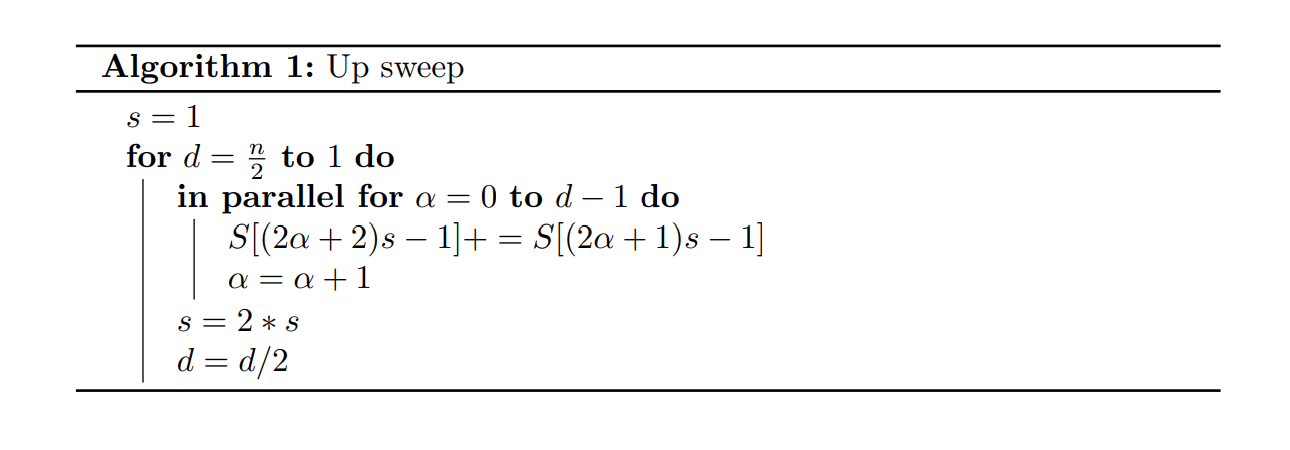

Note that in the last algorithm $\alpha$ is at most $n/2-1$ which means the number of threads used is half the size of the input array.


## Downsweep
After the upsweep is performed, the downsweep starts by setting the value of the root to 0. Then, going down the tree each node transfers the the sum of the left and its value to the right child and its own value to its left child.

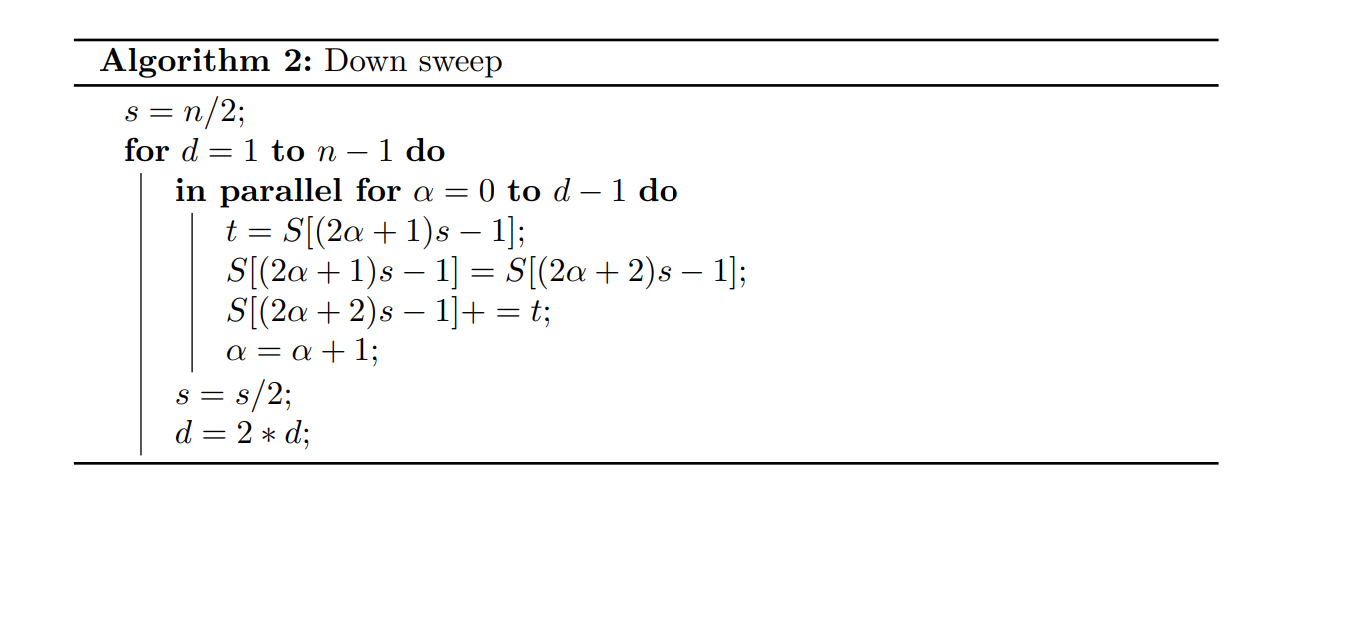


The downsweep of the example at the beginning is shown below
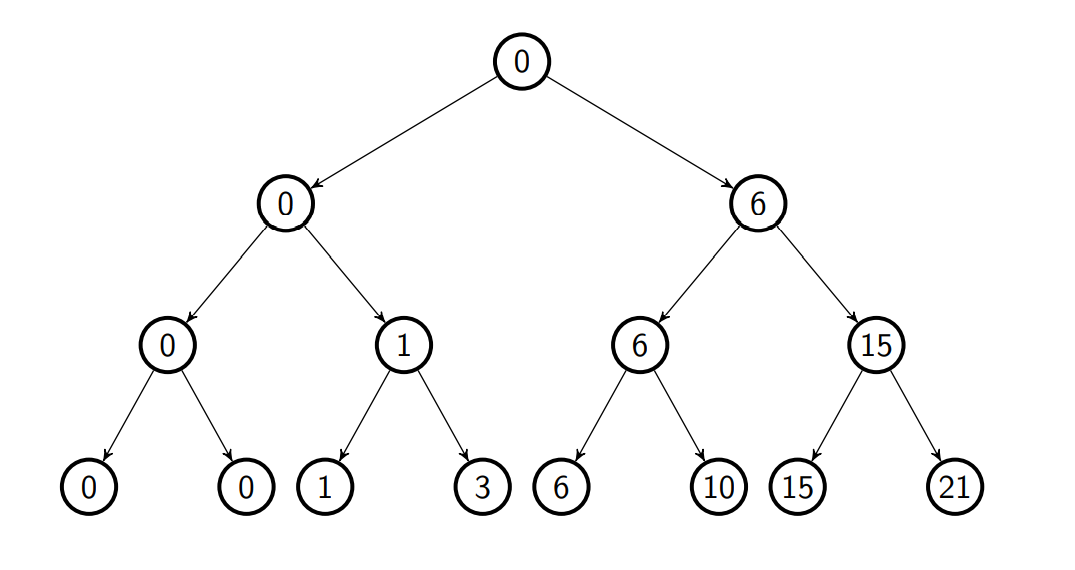

# Part 1

In this part assume that size is exactly 1024 elements. The scan on the input is computed by a **single** block. The signature of the CUDA kernel is as shown in the code below.
You must perform the computation in **shared memory**. Therefore the input is loaded into **shared memory** first.

### Note about shared memory

We have learned that **shared memory** is declared in a CUDA kernel as
```
__global__ void kernel(...){
  __shared__ float arr[size];
}

```

This syntax can be used when ```size``` is a constant. In our case we need to create shared memory dynamically and the above syntax will not do. We can allocated shared memory at kernel launch as follows

```
kernel<<<gridSize,blockSize,ssize>>>()
```

Where ```ssize``` is the shared memory size **in bytes**, so for ```n``` floats we would call it as

```
kernel<<<gridSize,blockSize,n*sizeof(float)>>>()

```
And inside the kernel

```
__global__ void kernel(...){

extern __shared__ arr[];

}

```

Write your code in the cell below

In [1]:
%%writefile scan1.cu

/* x is the input data, y is the result of exclusive scan
* and chunk_size is the input size which is assumed to be a power
* of 2 less or equal to 1024
*/

__global__ void exclusive_scan(float* x, float* y,const int chunk_size){
   
   extern __shared__ float temp[]; 
   int tid = threadIdx.x;
   int pout = 0, pin = 1;

   temp[tid] = (tid > 0) ? x[tid-1] : 0;
__syncthreads();
for( int offset = 1; offset < chunk_size; offset <<= 1 )
{
pout = 1 - pout; 
pin = 1 - pout;
if (tid >= offset)
temp[pout*chunk_size+tid] += temp[pin*chunk_size+tid - offset];
else
temp[pout*chunk_size+tid] = temp[pin*chunk_size+tid];
__syncthreads();
}
y[tid] = temp[pout*chunk_size+tid]; 
}
int main(){
    int num_items = 1024;

    float*  h_in = new float[num_items];

    for(int j=0;j<num_items;j++)
        h_in[j]=j;

    float *d_in = NULL;
    cudaMalloc(&d_in, sizeof(float) * num_items);

    cudaMemcpy(d_in, h_in, sizeof(float) * num_items, cudaMemcpyHostToDevice);

    float *d_out = NULL;
    cudaMalloc(&d_out, sizeof(float) * (num_items+1));

    exclusive_scan<<<1,1024,num_items*sizeof(float)>>>(d_in, d_out,num_items);

    float* h_out= new float[num_items+1];
    cudaMemcpy(h_out,d_out,sizeof(float)*(num_items+1),cudaMemcpyDeviceToHost);
    
     delete[] h_in;
     delete[] h_out;
     cudaFree(d_in);
     cudaFree(d_out);
}


Writing scan1.cu


In [12]:
!nvcc scan2.cu -o scan1 -run

scan2.cu(11): error: expression must have class type

scan2.cu(12): error: expression must have class type

2 errors detected in the compilation of "scan2.cu".


# Part2

To be able to handle input size which is **not** a multiple of 2 (but still less or equal to 1024) we pad the input with zeros. For example of the input size is 13 we add to it 3 zeros to make the length 16.

Add code to part1 to make chunk_size the smallest power of 2 bigger or equal to the input size. Test your code

In [11]:
%%writefile scan2.cu

/* handles input of any size less or equal to 1024
*/

__global__ void exclusive_scan(float* x, float* y,const int chunk_size){
   
   extern __shared__ float temp[]; 
   int tid = threadIdx.x;
   int pout = 0, pin = 1;

   while(x.size()%2 != 0)
			{x.push(0);}

   temp[tid] = (tid > 0) ? x[tid-1] : 0;
__syncthreads();
for( int offset = 1; offset < chunk_size; offset <<= 1 )
{
pout = 1 - pout; 
pin = 1 - pout;
if (tid >= offset)
temp[pout*chunk_size+tid] += temp[pin*chunk_size+tid - offset];
else
temp[pout*chunk_size+tid] = temp[pin*chunk_size+tid];
__syncthreads();
}
y[tid] = temp[pout*chunk_size+tid]; 
}
int main(){
    int num_items = 1025;

    float*  h_in = new float[num_items];

    for(int j=0;j<num_items;j++)
        h_in[j]=j;

    float *d_in = NULL;
    cudaMalloc(&d_in, sizeof(float) * num_items);

    cudaMemcpy(d_in, h_in, sizeof(float) * num_items, cudaMemcpyHostToDevice);

    float *d_out = NULL;
    cudaMalloc(&d_out, sizeof(float) * (num_items+1));

    exclusive_scan<<<1,1024,num_items*sizeof(float)>>>(d_in, d_out,num_items);

    float* h_out= new float[num_items+1];
    cudaMemcpy(h_out,d_out,sizeof(float)*(num_items+1),cudaMemcpyDeviceToHost);
    
     delete[] h_in;
     delete[] h_out;
     cudaFree(d_in);
     cudaFree(d_out);
}

Overwriting scan2.cu


# Part 3

In this part you need to compute exclusive scan for any input length. You can do that by dividing the input into chunks of size of chunk_size and computing the scan independently for each chunk. Each scan will be computed by a different block.
To combine the different parts consider the figure below. The sum of each block is already computed by the ```upsweep``` part of the algorithm. Before setting it to zero in the ```downsweep``` part we save it to an auxiliary array, one value per block.

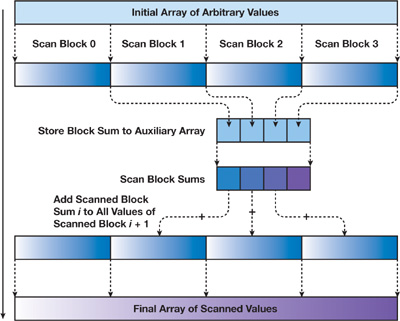

In this part we need 3 kernel calls: 
1. the first is to compute the scan for each block independently, while saving the sum in an auxilary array.
1. The second is to compute the scan for the sums, i.e. for the values in the auxilary array
1. The third is to add the previous two parts as show in the figure above.

In [13]:
__global__ void exclusive_scan(float* x, float* y,float *aux,const int chunk_size){
    extern __shared float sdata[];


    int tid = threadIdx.x;
    int i = blockDim.x * blockIdx.x + threadIdx.x;

    int old_chunck_size= chunck_size;

    if(i == 0 && (log2(chunck_size) == ceil(log2(chunck_size)))){
        
         chunck_size += pow(ceil(log2(chunck_size)),2) - chunck_size;
    
    }
    if(i != 0)
    if(i >= old_chunck_size && i < chunck_size;)
    x[i] = 0;           //padding with 0
    __syncthreads();

    int real_index = 2* tid + blockDim.x * 2 * blockIdx.x;
    int index + 2*tid;

    int offset = 1;

    //load input into shared memory
    sdata[index] = x[real_index];
    sdata[index+1] = x[real_index + 1];
    

    for(int d = chunck_size>>1; d>0; d>>=1)
    {   
        __syncthreads();
     
        if(tid < d)
        {
            int ai = offset*(index+1)-1;
            int bi = offset*(index+2)-1;
         
            sdata[bi] += sdata[ai];
        }
      offset*=2;
    
    }

    if(tid == 0)
    {    
        
        if(aux){
            aux[blockIdx.x]=sdata[chunck_size-1];
            }
        sdata[chunck_size-1] = 0;
    }

    for(int d = 1; d<blockDim.x*2; d*=2)//downsweep
    {
        offset >>= 1;
        __syncthreads();
     
        if(tid< d)
        {
            int ai = offset*(index+1)-1;
            int bi = offset*(index+2)-1;
         
            float t = sdata[ai];
            sdata[ai] = sdata[bi];
            sdata[bi] += t;
        }
    }
    __syncthreads();


    y[real_index] = sdata[index];
    y[real_index+1] = sdata[index+1];
}


SyntaxError: ignored

# Part 4

### Matrix transpose

Write CUDA code to compute the transpose of a **square** matrix $A$. The result is stored in matrix $B$, i.e. $B=A^T$.
$$
B[i][j]=A[j][i]
$$
Both matrices are stored as arrays and you should make use of shared memory

In [3]:
%%writefile transpose.cu

__global__ void transpose (float *out, float *in, int width, int height )
{
    unsigned int xIdx = blockDim.x * blockIdx.x + threadIdx.x;
    unsigned int yIdx = blockDim.y * blockIdx.y + threadIdx.y;
    if ( xIdx <=width && yIdx <=height ) {
        unsigned int idx_in = xIdx + width * yIdx;
        unsigned int idx_out = yIdx + height * xIdx;
        out[idx_out] = in[idx_in];
    }
}
int main(){
    int nx=1024;
    int mem_size = nx*nx*sizeof(float);
    int t=32;
    dim3 dimGrid(((nx-1)/t) +1, ((nx-1)/t) +1);
    dim3 dimBlock(t,t);

    float *h_idata = (float*)malloc(mem_size);
    float *h_tdata = (float*)malloc(mem_size);
    float *d_idata, *d_tdata;
    cudaMalloc(&d_idata, mem_size);
    cudaMalloc(&d_tdata, mem_size);   
   
    for (int j = 0; j < nx; j++)
        for (int i = 0; i < nx; i++)
            h_idata[j*nx + i] = j*nx + i;

    
    cudaMemcpy(d_idata, h_idata, mem_size, cudaMemcpyHostToDevice);

    transpose<<<dimGrid, dimBlock>>>(d_tdata, d_idata,nx,nx);
    
    cudaMemcpy(h_tdata, d_tdata, mem_size, cudaMemcpyDeviceToHost);

    cudaFree(d_tdata);
    cudaFree(d_idata);
    free(h_idata);
    free(h_tdata);
    
}


Writing transpose.cu


In [4]:
!nvcc transpose.cu -o transpose -run